In [11]:
#!pip install neuralprophet


In [16]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from prophet import Prophet

# Load the data
data = yf.download('AMZN', start='2000-01-01', end='2024-06-14').reset_index()
data.set_index('Date', inplace=True)
data = data['Close'].asfreq('D').fillna(method='ffill')

[*********************100%%**********************]  1 of 1 completed


# **ARIMA MODEL**

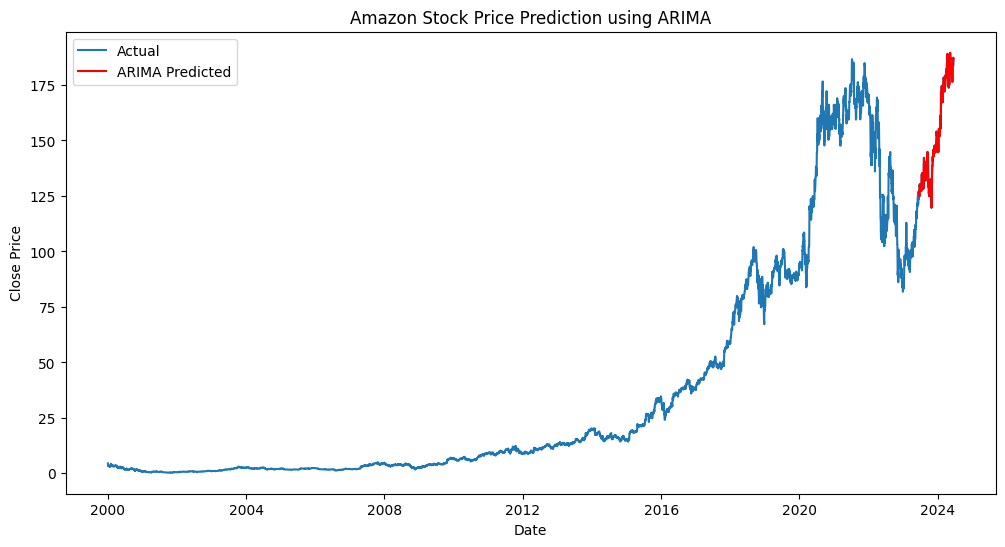

In [17]:
# ARIMA Model
model_arima = ARIMA(data, order=(5, 1, 0))
model_arima_fit = model_arima.fit()

# ARIMA predictions
forecast_steps = 365  # Forecasting one year ahead
forecast_arima = model_arima_fit.forecast(steps=forecast_steps)

train_end = len(data) - forecast_steps
train_data = data[:train_end]
test_data = data[train_end:]

predicted_data_arima = model_arima_fit.predict(start=train_end, end=len(data)-1, dynamic=False)

mae_arima = mean_absolute_error(test_data, predicted_data_arima)
mse_arima = mean_squared_error(test_data, predicted_data_arima)
rmse_arima = np.sqrt(mse_arima)
r2_arima = r2_score(test_data, predicted_data_arima)
mape_arima = mean_absolute_percentage_error(test_data, predicted_data_arima)
accuracy_arima = 100 - mape_arima

# Plotting ARIMA
plt.figure(figsize=(12, 6))
plt.plot(data, label='Actual')
plt.plot(test_data.index, predicted_data_arima, label='ARIMA Predicted', color='red')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Amazon Stock Price Prediction using ARIMA')
plt.show()

# **LSTM MODEL**

56/56 [==============================] - 2s 26ms/step


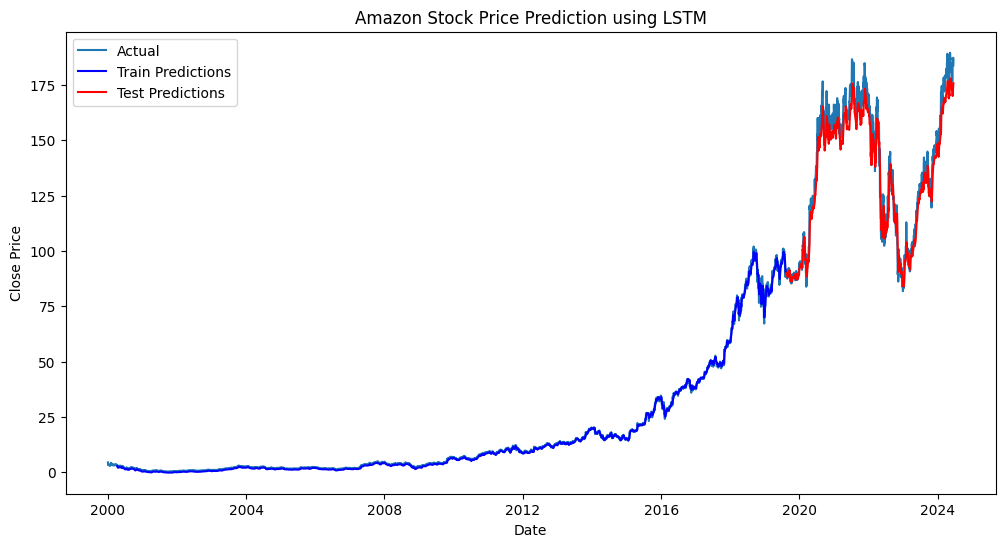

In [18]:
# LSTM Model
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data.values.reshape(-1, 1))

def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

time_step = 100
X_lstm, y_lstm = create_dataset(scaled_data, time_step)

train_size = int(len(X_lstm) * 0.8)
test_size = len(X_lstm) - train_size
X_train_lstm, X_test_lstm = X_lstm[0:train_size], X_lstm[train_size:len(X_lstm)]
y_train_lstm, y_test_lstm = y_lstm[0:train_size], y_lstm[train_size:len(y_lstm)]

X_train_lstm = X_train_lstm.reshape(X_train_lstm.shape[0], X_train_lstm.shape[1], 1)
X_test_lstm = X_test_lstm.reshape(X_test_lstm.shape[0], X_test_lstm.shape[1], 1)

model_lstm = Sequential()
model_lstm.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model_lstm.add(LSTM(50, return_sequences=False))
model_lstm.add(Dense(25))
model_lstm.add(Dense(1))

model_lstm.compile(optimizer='adam', loss='mean_squared_error')
model_lstm.fit(X_train_lstm, y_train_lstm, batch_size=1, epochs=1)

train_predict_lstm = model_lstm.predict(X_train_lstm)
test_predict_lstm = model_lstm.predict(X_test_lstm)

train_predict_lstm = scaler.inverse_transform(train_predict_lstm)
test_predict_lstm = scaler.inverse_transform(test_predict_lstm)

rmse_train_lstm = np.sqrt(mean_squared_error(y_train_lstm, train_predict_lstm))
rmse_test_lstm = np.sqrt(mean_squared_error(y_test_lstm, test_predict_lstm))

r2_train_lstm = r2_score(y_train_lstm, train_predict_lstm)
r2_test_lstm = r2_score(y_test_lstm, test_predict_lstm)

mape_train_lstm = mean_absolute_percentage_error(y_train_lstm, train_predict_lstm)
mape_test_lstm = mean_absolute_percentage_error(y_test_lstm, test_predict_lstm)

accuracy_train_lstm = 100 - mape_train_lstm
accuracy_test_lstm = 100 - mape_test_lstm

# Plotting LSTM
plt.figure(figsize=(12, 6))
plt.plot(data.index, data.values, label='Actual')
plt.plot(data.index[time_step:time_step+len(train_predict_lstm)], train_predict_lstm, label='Train Predictions', color='blue')
plt.plot(data.index[time_step+len(train_predict_lstm)+1:], test_predict_lstm, label='Test Predictions', color='red')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Amazon Stock Price Prediction using LSTM')
plt.show()

# **PROPHET MODEL**

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3w2bchcq/vztrp_9y.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3w2bchcq/r4j6iz_d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56309', 'data', 'file=/tmp/tmp3w2bchcq/vztrp_9y.json', 'init=/tmp/tmp3w2bchcq/r4j6iz_d.json', 'output', 'file=/tmp/tmp3w2bchcq/prophet_models9gur0gm/prophet_model-20240707073915.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:39:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:39:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


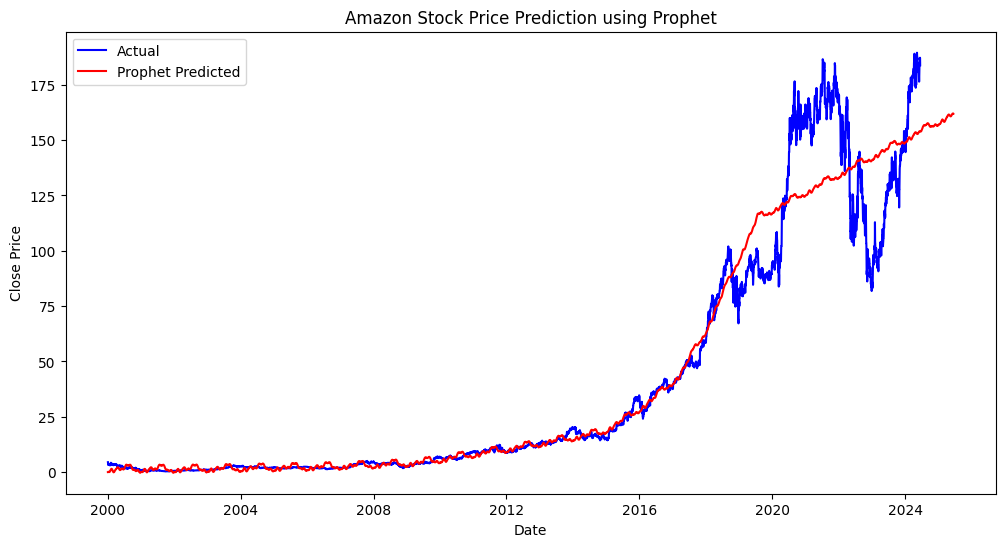

In [26]:
# Prophet Model
data_prophet = data.reset_index()
data_prophet.columns = ['ds', 'y']

model_prophet = Prophet()
model_prophet.fit(data_prophet)

future = model_prophet.make_future_dataframe(periods=365)
forecast_prophet = model_prophet.predict(future)

y_true_prophet = data_prophet['y']
y_pred_prophet = forecast_prophet['yhat'][:len(data_prophet)]

mae_prophet = mean_absolute_error(y_true_prophet, y_pred_prophet)
mse_prophet = mean_squared_error(y_true_prophet, y_pred_prophet)
rmse_prophet = np.sqrt(mse_prophet)
r2_prophet = r2_score(y_true_prophet, y_pred_prophet)
mape_prophet = mean_absolute_percentage_error(y_true_prophet, y_pred_prophet)
accuracy_prophet = 100 - mape_prophet

# Plotting Prophet
# model_prophet.plot(forecast_prophet)
# plt.title('Amazon Stock Price Prediction using Prophet')
# plt.xlabel('Date')
# plt.ylabel('Close Price')
# plt.show()
plt.figure(figsize=(12, 6))
plt.plot(data_prophet['ds'], data_prophet['y'], label='Actual', color='blue')
plt.plot(forecast_prophet['ds'], forecast_prophet['yhat'], label='Prophet Predicted', color='red')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Amazon Stock Price Prediction using Prophet')
plt.show()

# **LINEAR REGRESSION**

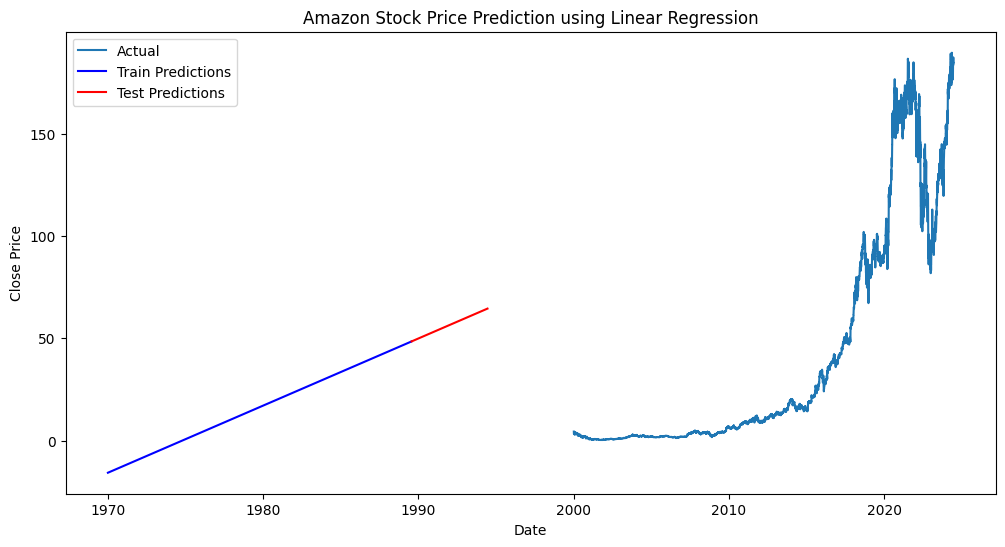

In [20]:
# Linear Regression Model
data_linear = data.reset_index()
data_linear['Days'] = (data_linear['Date'] - data_linear['Date'].min()).dt.days

X = data_linear[['Days']]
y = data_linear['Close']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

y_train_pred_lr = model_lr.predict(X_train)
y_test_pred_lr = model_lr.predict(X_test)

mae_train_lr = mean_absolute_error(y_train, y_train_pred_lr)
mse_train_lr = mean_squared_error(y_train, y_train_pred_lr)
rmse_train_lr = np.sqrt(mse_train_lr)
r2_train_lr = r2_score(y_train, y_train_pred_lr)
mape_train_lr = mean_absolute_percentage_error(y_train, y_train_pred_lr)
accuracy_train_lr = 100 - mape_train_lr

mae_test_lr = mean_absolute_error(y_test, y_test_pred_lr)
mse_test_lr = mean_squared_error(y_test, y_test_pred_lr)
rmse_test_lr = np.sqrt(mse_test_lr)
r2_test_lr = r2_score(y_test, y_test_pred_lr)
mape_test_lr = mean_absolute_percentage_error(y_test, y_test_pred_lr)
accuracy_test_lr = 100 - mape_test_lr


# Plotting Linear Regression
plt.figure(figsize=(12, 6))
plt.plot(data.index, data, label='Actual')
plt.plot(X_train.index, y_train_pred_lr, label='Train Predictions', color='blue')
plt.plot(X_test.index, y_test_pred_lr, label='Test Predictions', color='red')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Amazon Stock Price Prediction using Linear Regression')
plt.show()

In [21]:
# Display accuracy metrics
print('ARIMA MAE:', mae_arima)
print('ARIMA MSE:', mse_arima)
print('ARIMA RMSE:', rmse_arima)
print('ARIMA R2:', r2_arima)
print('ARIMA Accuracy:', accuracy_arima)

print(f'Linear Regression Training MAE: {mae_train_lr}')
print(f'Linear Regression Training MSE: {mse_train_lr}')
print(f'Linear Regression Training RMSE: {rmse_train_lr}')
print(f'Linear Regression Training R2: {r2_train_lr}')
print(f'Linear Regression Training Accuracy: {accuracy_train_lr}')
print(f'Linear Regression Testing MAE: {mae_test_lr}')
print(f'Linear Regression Testing MSE: {mse_test_lr}')
print(f'Linear Regression Testing RMSE: {rmse_test_lr}')
print(f'Linear Regression Testing R2: {r2_test_lr}')
print(f'Linear Regression Testing Accuracy: {accuracy_test_lr}')

print(f'LSTM Training RMSE: {rmse_train_lstm}')
print(f'LSTM Testing RMSE: {rmse_test_lstm}')
print(f'LSTM Training R2: {r2_train_lstm}')
print(f'LSTM Testing R2: {r2_test_lstm}')
print(f'LSTM Training Accuracy: {accuracy_train_lstm}')
print(f'LSTM Testing Accuracy: {accuracy_test_lstm}')

print(f'Prophet MAE: {mae_prophet}')
print(f'Prophet MSE: {mse_prophet}')
print(f'Prophet RMSE: {rmse_prophet}')
print(f'Prophet R2: {r2_prophet}')
print(f'Prophet Accuracy: {accuracy_prophet}')

ARIMA MAE: 1.3456897994166996
ARIMA MSE: 4.519333128014685
ARIMA RMSE: 2.125872321663435
ARIMA R2: 0.9899389108588222
ARIMA Accuracy: 99.99106863577813
Linear Regression Training MAE: 11.490227635310955
Linear Regression Training MSE: 223.8793232642761
Linear Regression Training RMSE: 14.96259747718544
Linear Regression Training R2: 0.6048715479389419
Linear Regression Training Accuracy: 96.87945957252005
Linear Regression Testing MAE: 79.69534577418953
Linear Regression Testing MSE: 7261.448882397913
Linear Regression Testing RMSE: 85.21413546118926
Linear Regression Testing R2: -6.558852070027631
Linear Regression Testing Accuracy: 99.43703435320242
LSTM Training RMSE: 29.18558204169341
LSTM Testing RMSE: 134.85119930511914
LSTM Training R2: -52016.64522621974
LSTM Testing R2: -685585.6767924218
LSTM Training Accuracy: -296022112137.445
LSTM Testing Accuracy: -83.84624591827705
Prophet MAE: 7.1001015561502
Prophet MSE: 193.8154213168612
Prophet RMSE: 13.921760711808734
Prophet R2: 0.

In [28]:
#metrics comparison
metrics = {
    'ARIMA': {'MAE': mae_arima, 'MSE': mse_arima, 'RMSE': rmse_arima, 'R2': r2_arima, 'Accuracy': accuracy_arima},
    'Linear Regression (Test)': {'MAE': mae_test_lr, 'MSE': mse_test_lr, 'RMSE': rmse_test_lr, 'R2': r2_test_lr, 'Accuracy': accuracy_test_lr},
    'LSTM (Test)': {'RMSE': rmse_test_lstm, 'Accuracy': accuracy_test_lstm, 'R2' : r2_test_lstm},
    'Prophet': {'MAE': mae_prophet, 'MSE': mse_prophet, 'RMSE': rmse_prophet, 'R2': r2_prophet, 'Accuracy': accuracy_prophet},
}

# Printing the metrics for comparison
for model_name, metrics_dict in metrics.items():
    print(f"\nModel: {model_name}")
    for metric, value in metrics_dict.items():
        print(f"{metric}: {value}")

# Finding the model with the highest Accuracy
best_model = max(metrics, key=lambda model: metrics[model]['Accuracy'])
print(f"\nThe best model based on Accuracy is: {best_model}")



Model: ARIMA
MAE: 1.3456897994166996
MSE: 4.519333128014685
RMSE: 2.125872321663435
R2: 0.9899389108588222
Accuracy: 99.99106863577813

Model: Linear Regression (Test)
MAE: 79.69534577418953
MSE: 7261.448882397913
RMSE: 85.21413546118926
R2: -6.558852070027631
Accuracy: 99.43703435320242

Model: LSTM (Test)
RMSE: 134.85119930511914
Accuracy: -83.84624591827705
R2: -685585.6767924218

Model: Prophet
MAE: 7.1001015561502
MSE: 193.8154213168612
RMSE: 13.921760711808734
R2: 0.9341005897732848
Accuracy: 99.65373572595428

The best model based on Accuracy is: ARIMA
